In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb 
# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [2]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("train_v2.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv("store.csv")

In [3]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))

No closed store with sales: True


In [4]:
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))

No open store with no sales: True


In [5]:
train = train.loc[train['Sales'] > 0]
assert(train[train['Sales'] == 0].size == 0)

In [6]:
dates = pd.to_datetime(train['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))

Start date:  2014-11-26 00:00:00
End Date:  2015-01-30 00:00:00


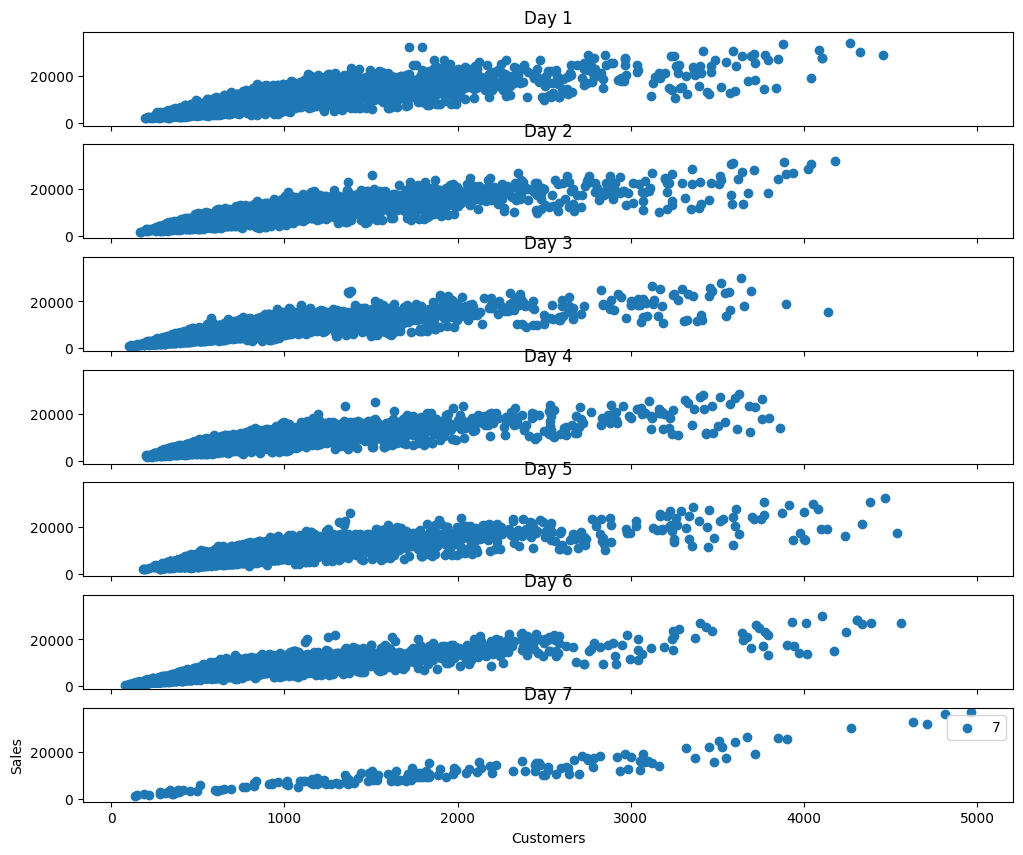

In [7]:
f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

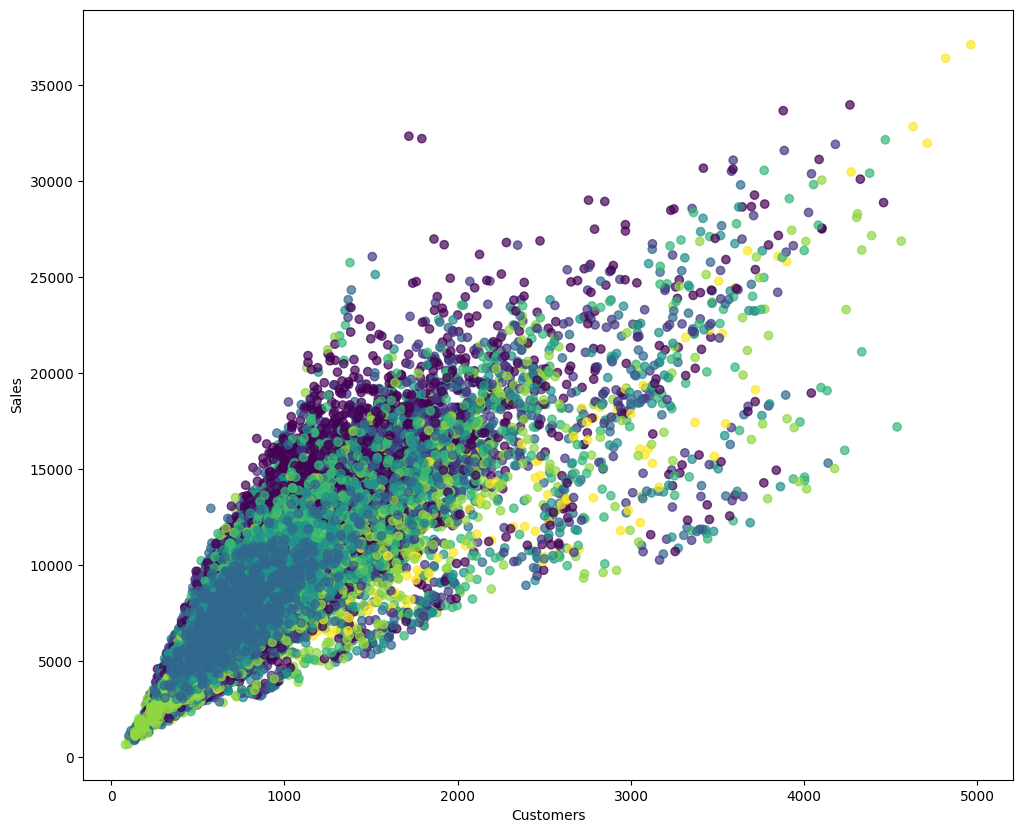

In [8]:
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7) #cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

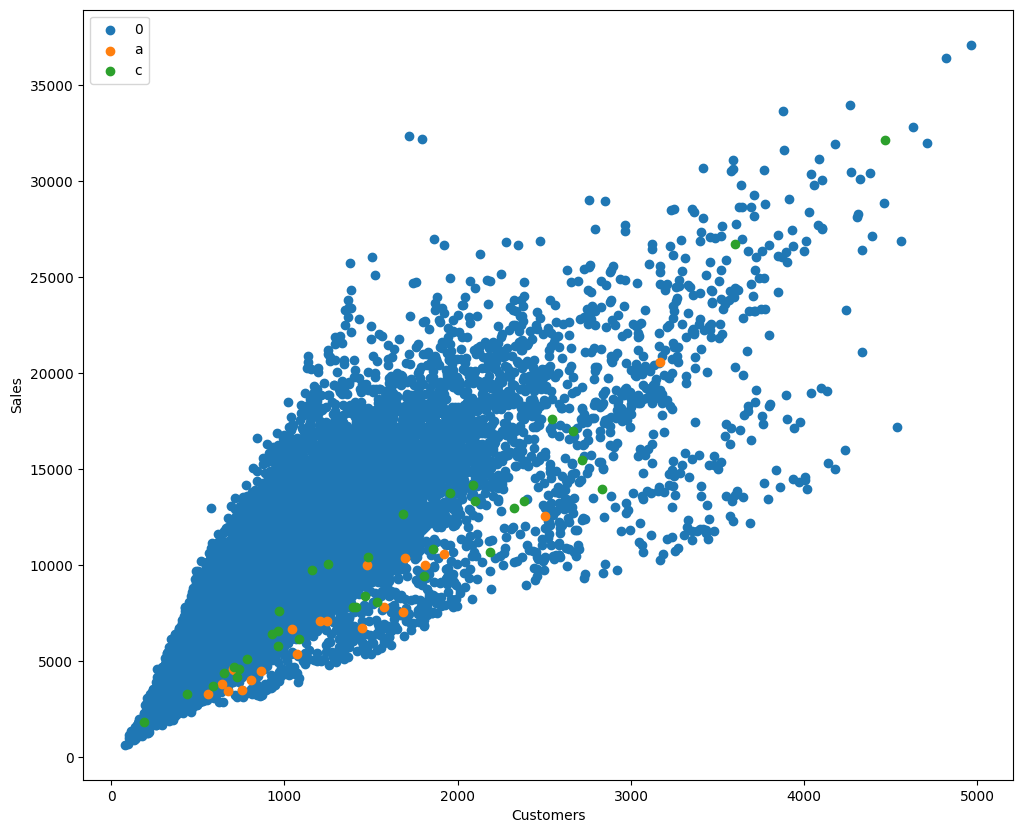

In [9]:
for i in ["0", "a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

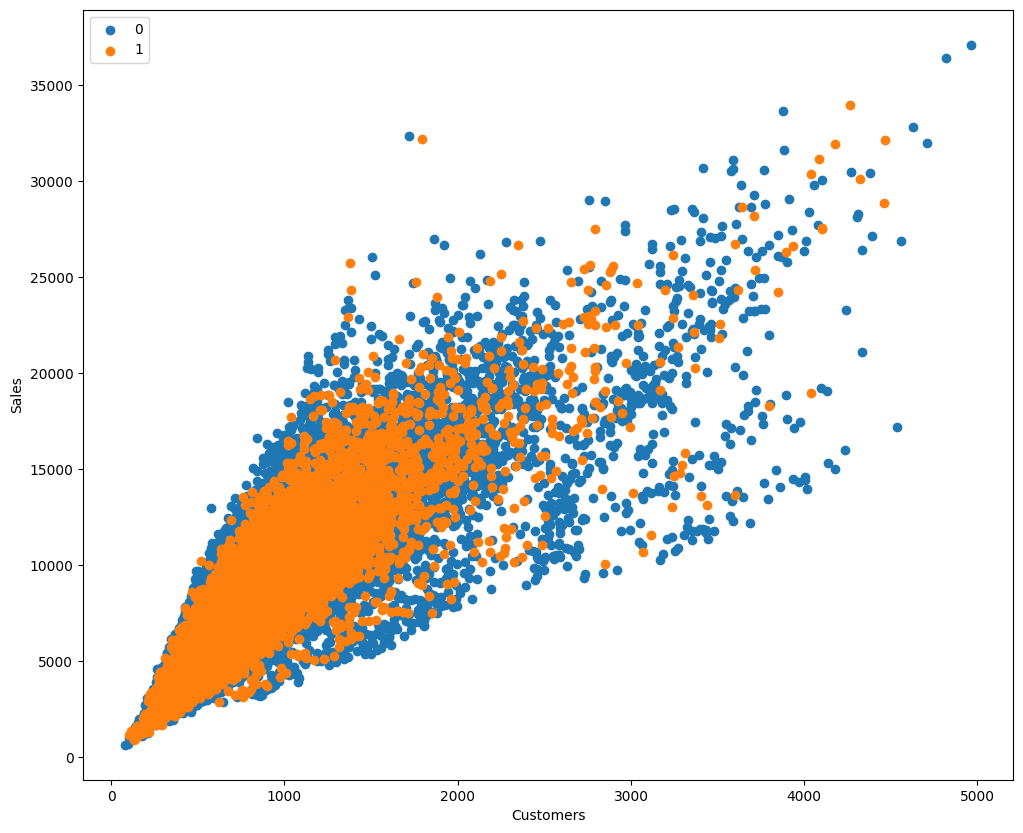

In [10]:
for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

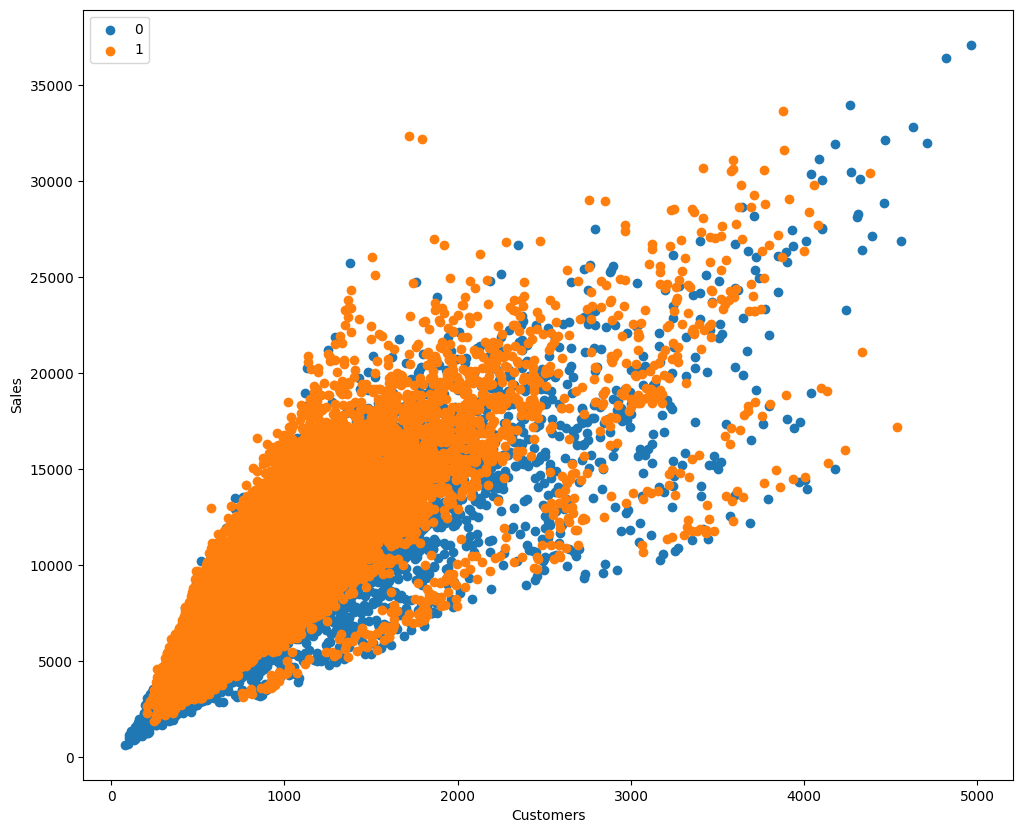

In [11]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

In [12]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()

,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5574.037037,644.407407,8.574182,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5593.407407,602.833333,9.132443,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,7560.740741,797.296296,9.363221,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,10730.296296,1424.888889,7.481731,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5313.981481,564.833333,9.273212,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


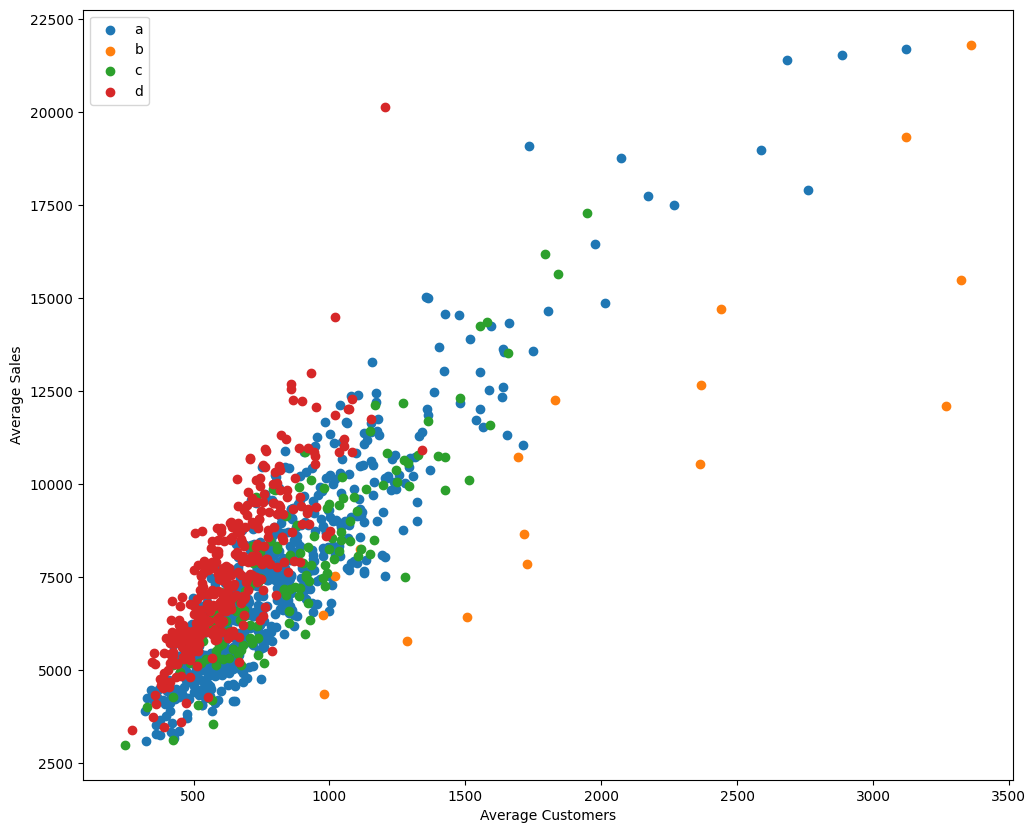

In [13]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

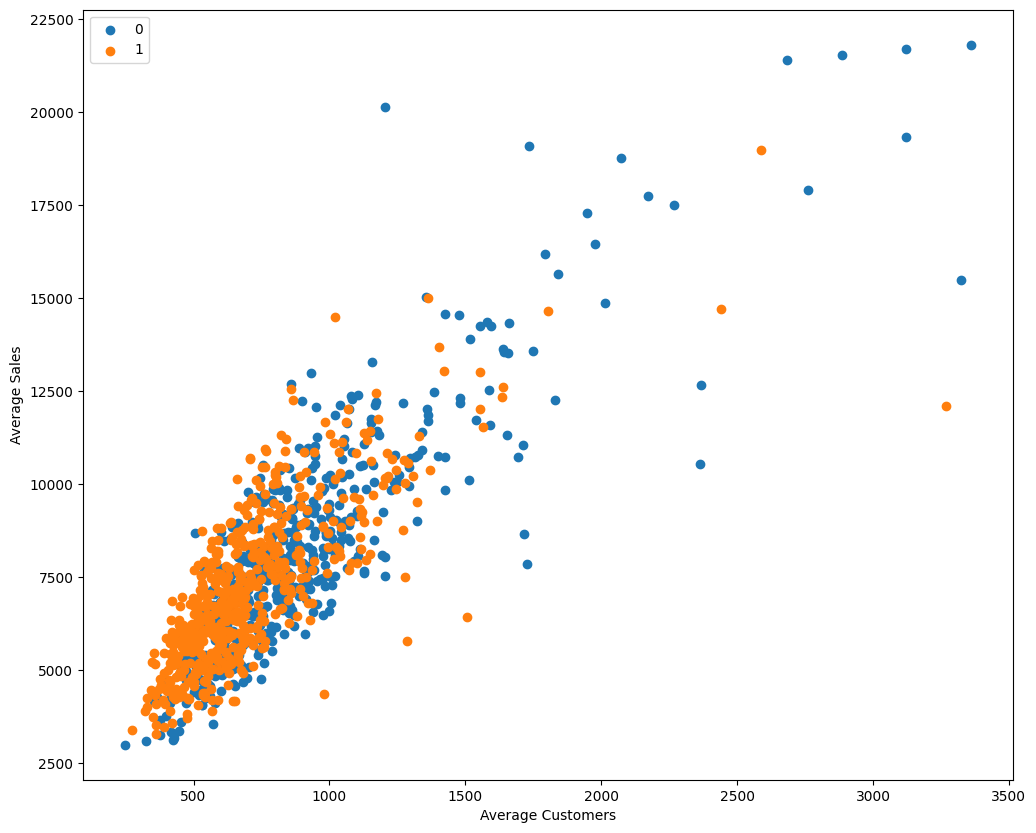

In [14]:
for i in [0, 1]:
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()

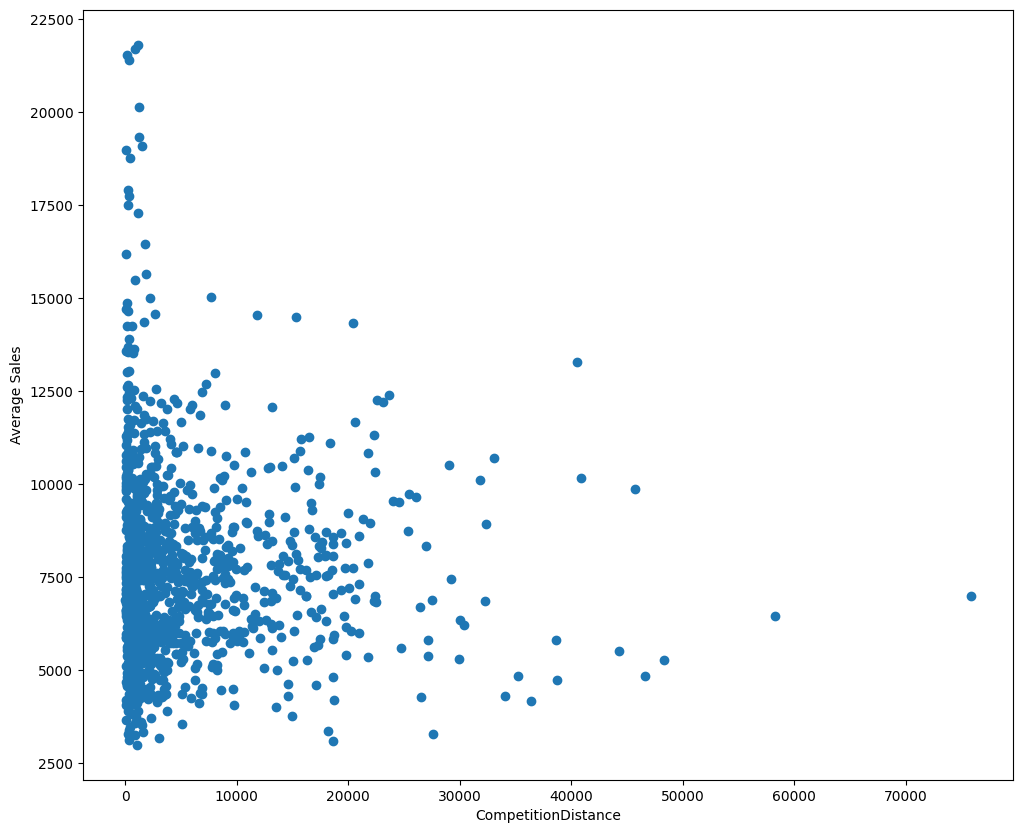

In [15]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()

In [16]:
def build_features(train, store):
    # Convert string types into integers
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')
    
    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)
    
    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.week
    
    # Number of months that competitiZon has existed for
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace
    
    # Number of weeks that promotion has existed for
    merged['WeeksPromoOpen'] = \
        12 * (merged['Year'] - merged['Promo2SinceYear']) + \
        (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] == 
               NaN_replace, 'WeeksPromoOpen'] = NaN_replace

    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 
        'Promo2SinceYear', 
        'MonthsCompetitionOpen', 
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()

AttributeError: 'DatetimeProperties' object has no attribute 'week'

In [28]:
from sklearn.model_selection import train_test_split
X = [
    'Store', 
    'Customers',
    'CompetitionDistance', 

    'Promo', 
    'Promo2', 

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',
    
    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)

NameError: name 'features' is not defined

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Error calculating function according to kaggle
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)

In [30]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)

NameError: name 'X_train' is not defined

In [31]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)

NameError: name 'X_test' is not defined

In [32]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)

NameError: name 'X_train' is not defined

In [33]:
y_hat = randomForest.predict(X_test)
score(randomForest, X_train, y_train, y_test, y_hat)

NameError: name 'X_test' is not defined

In [2]:
%pip install xgboost
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[X], np.log1p(y_train), 
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\http\client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/a2/48/d5da8591891327b0faf08179d420fba3893c6134bdd449497c5329e4cb01/xgboost-2.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   -----------

ModuleNotFoundError: No module named 'xgboost'

Note that this is not in percentage, thus not to scale of graphs above


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

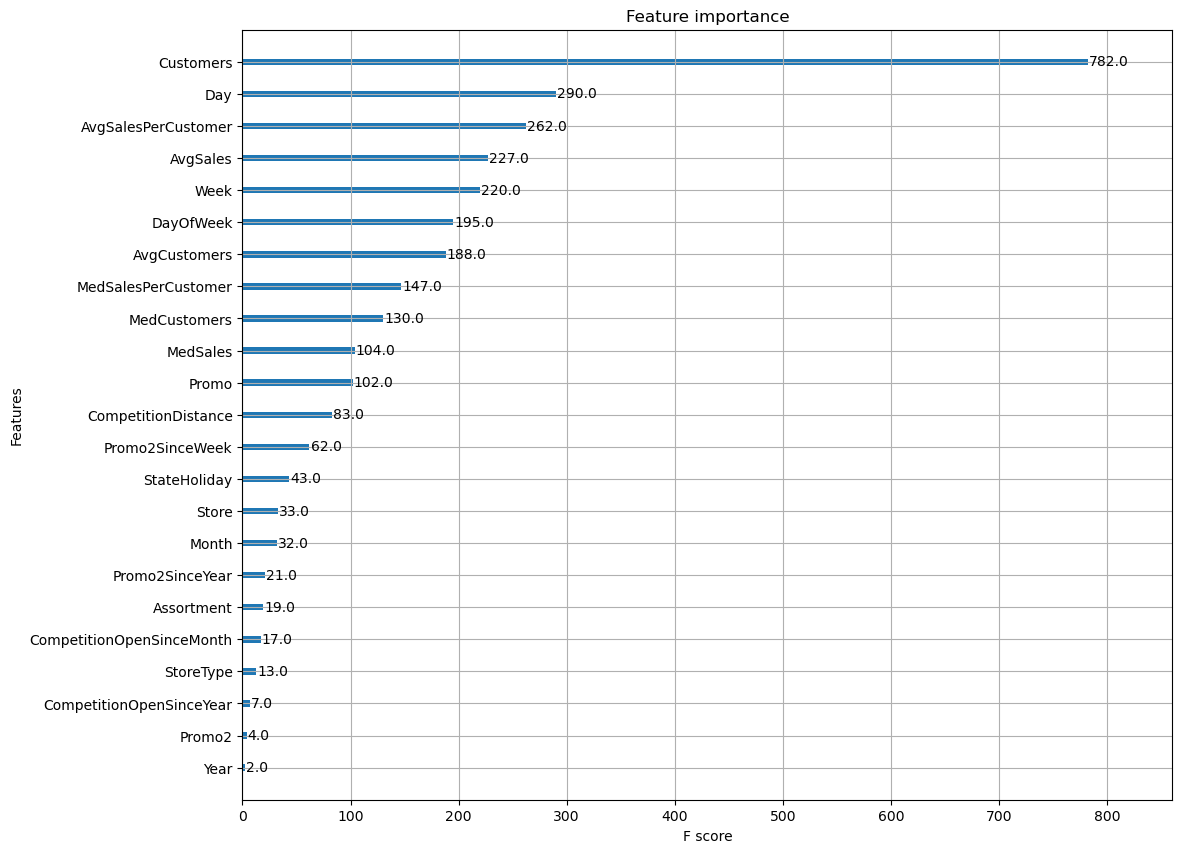

In [ ]:
print("Note that this is not in percentage, thus not to scale of graphs above")
xgb.plot_importance(xgboost_tree)

In [ ]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)

C:\Users\admin\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [22:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\admin\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning:

Mean -0.05527399756181465
Variance 2.1195917600129122e-07
RMSPE 0.054297836525485525


In [ ]:
test = pd.read_csv("test_v2.csv", parse_dates=[2], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('sales.csv', index=False)

C:\Users\admin\AppData\Local\Temp\ipykernel_9564\760113941.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  merged['Week'] = merged.Date.dt.week
C:\Users\admin\AppData\Local\Temp\ipykernel_9564\760113941.py:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
